In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import pickle 
import cortex
import sys
import nibabel as nib
from nibabel.freesurfer.io import read_morph_data, write_morph_data
import cortex

In [26]:
subj = 'sub-02'
target = 'V3' # or 'V3'
source = 'V1'
hemi = 'rh' # or 'rh'
atlas = 'manual' # or 'benson'
delineation = 'manualdelin'
denoising = 'nordic' # or 'nordic_sm4
task = 'RET' # or 'RET2' or 'Resting_State'
best_fit = f'/Volumes/FedericaCardillo/results/{subj}/{hemi}/{target}->{source}/best_fits.csv' 
MAIN_PATH = '/Volumes/FedericaCardillo/pre-processing/projects/EGRET+/derivatives'
freesurfer = f"{MAIN_PATH}/freesurfer"
labels = f"{freesurfer}/{subj}/label/{hemi}.{delineation}.label"
supervoxel = True 

In [27]:
# EXTRACT THE POPULATION RECEPTIVE FIELD PROPERTIES 
# 1. Load the file with the best fits
best_fit = pd.read_csv(best_fit)
best_fit

,Target Vertex Index,Source Vertex Index,Best Sigma Coarse,Best Sigma Finer,Best Variance Explained Coarse,Best Variance Explained Finer
0,2241,3134,1.085711,1.091808,0.837885,0.837898
1,2641,3111,1.341378,1.364039,0.720317,0.720665
2,2240,3120,1.085711,1.074790,0.840577,0.840629
3,2255,1897,0.377164,0.374218,0.843667,0.843670
4,2242,1897,0.419227,0.430362,0.852621,0.852654
...,...,...,...,...,...,...
1289,9066,10408,0.419227,0.437404,0.378951,0.379263
1290,13837,4656,0.247091,0.244678,0.325003,0.325003
1291,133029,5255,0.339322,0.337268,0.240158,0.240159
1292,7758,9619,0.339322,0.357282,0.555133,0.555410


In [ ]:
# 2. Load the pickle file with the pRF mapping results
class PRFModel:
    def __init__(self, r2, size, ecc, angle):
        self.r2 = r2        
        self.size = size
        self.ecc = ecc    
        self.angle = angle     

def load_pickle_file(filepath):
    if not os.path.isfile(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")
    with open(filepath, 'rb') as file: 
        return pickle.load(file)

def load_prf_params(subj, main_path, atlas, denoising, task):
    filepath = os.path.join(main_path, f'pRFM/{subj}/ses-02/{denoising}/model-{atlas}-nelder-mead-GM_desc-prf_params_{task}.pkl') 
    pkl_data = load_pickle_file(filepath)                       
    prf_params = pkl_data['model'].iterative_search_params     
    prf_voxels = np.where(pkl_data['rois_mask'] == 1)[0]    ## CHECK THIS.  
    prf_voxels= prf_voxels
    return prf_params, prf_voxels

def filter_prf_data(prf_params, prf_voxels):
    return PRFModel(
        r2=prf_params[:, 7],                                              
        size=prf_params[:, 2],                                              
        ecc=np.sqrt(prf_params[:, 1]**2 + prf_params[:, 0]**2),      
        angle=np.arctan2(prf_params[:, 1], prf_params[:, 0]))

# 3. Assign pRF propreties
def extract_prf_properties(subj, MAIN_PATH, atlas, denoising, task, csv_path):
    # best_fit = pd.read_csv(best_fit)
    prf_params, prf_voxels = load_prf_params(subj, MAIN_PATH, atlas, denoising, task)
    prf_model = filter_prf_data(prf_params, prf_voxels)
    lh_c = read_morph_data(f'{freesurfer}/{subj}/surf/lh.curv')
    numel_lh = lh_c.shape[0]
    #voxel_to_ecc = dict(zip(prf_voxels, prf_model.ecc))
    #voxel_to_angle = dict(zip(prf_voxels, prf_model.angle))

    if hemi == 'rh':
        prf_voxels_rh = prf_voxels[prf_voxels >= numel_lh] # [0 1 2 ... 248451 248457 248464] that are higher than 125206 = [125206 125207 125208 ... 248451 248457 248464]
        prf_voxels_rh_adjusted = prf_voxels_rh - numel_lh 
        prf_ecc_rh = prf_model.ecc[prf_voxels >= numel_lh] 
        prf_angle_rh = prf_model.angle[prf_voxels >= numel_lh]
        voxel_to_ecc = dict(zip(prf_voxels_rh_adjusted, prf_ecc_rh))
        voxel_to_angle = dict(zip(prf_voxels_rh_adjusted, prf_angle_rh))
    else: 
        voxel_to_ecc = dict(zip(prf_voxels, prf_model.ecc))
        voxel_to_angle = dict(zip(prf_voxels, prf_model.angle))
    
    best_fit['Source Eccentricity'] = best_fit['Source Vertex Index'].map(voxel_to_ecc)
    best_fit['Source Polar Angle'] = best_fit['Source Vertex Index'].map(voxel_to_angle)

    output = f'/Volumes/FedericaCardillo/results/{subj}/{hemi}/{target}->{source}/best_fits_prf.csv'
    best_fit.to_csv(output, index=False)
    
    return best_fit

best_fit_prf = extract_prf_properties(subj, MAIN_PATH, atlas, denoising, task, best_fit)
best_fit_prf

IndexError: boolean index did not match indexed array along dimension 0; dimension is 23802 but corresponding boolean dimension is 313380

In [31]:
# ECCENTRICITY
# Assign to each voxel in the target area the eccentricity of the best fit in the source area 
target_idx = best_fit_prf['Target Vertex Index'].values.astype(int)
target_ecc = best_fit_prf['Source Eccentricity'].values
curv = read_morph_data(f'{freesurfer}/{subj}/surf/{hemi}.curv')
# curv = read_morph_data(f'{freesurfer}/{subj}/surf/lh.curv')
masked_ecc = np.zeros(curv.shape[0])
masked_ecc[:] = 50 
masked_ecc[target_idx] = target_ecc
ecc_output = f'{freesurfer}/{subj}/surf/{hemi}.ecc_{target}{source}'
write_morph_data(ecc_output, masked_ecc)

# POLAR ANGLE 
target_idx = best_fit_prf['Target Vertex Index'].values.astype(int)
target_pol = best_fit_prf['Source Polar Angle'].values
masked_pol = np.zeros(curv.shape[0])
masked_pol[:] = 50 
masked_pol[target_idx] = target_pol
pol_output = f'{freesurfer}/{subj}/surf/{hemi}.pol_{target}{source}'
write_morph_data(pol_output, masked_pol)
print(masked_pol)

# VARIANCE EXPLAINED 
target_idx = best_fit_prf['Target Vertex Index'].values.astype(int)
target_ve = best_fit_prf['Best Variance Explained Finer'].values
masked_ve = np.zeros(curv.shape[0])
masked_ve[:] = 50 
masked_ve[target_idx] = target_ve
ve_output = f'{freesurfer}/{subj}/surf/{hemi}.ve_{target}{source}'
write_morph_data(ve_output, masked_ve)

# SIGMA 
target_idx = best_fit_prf['Target Vertex Index'].values.astype(int)
target_sigma = best_fit_prf['Best Sigma Finer'].values
masked_sigma = np.zeros(curv.shape[0])
masked_sigma[:] = 50 
masked_sigma[target_idx] = target_sigma
sigma_output = f'{freesurfer}/{subj}/surf/{hemi}.sigma_{target}{source}_finer'
write_morph_data(sigma_output, masked_sigma)

[50. 50. 50. ... 50. 50. 50.]


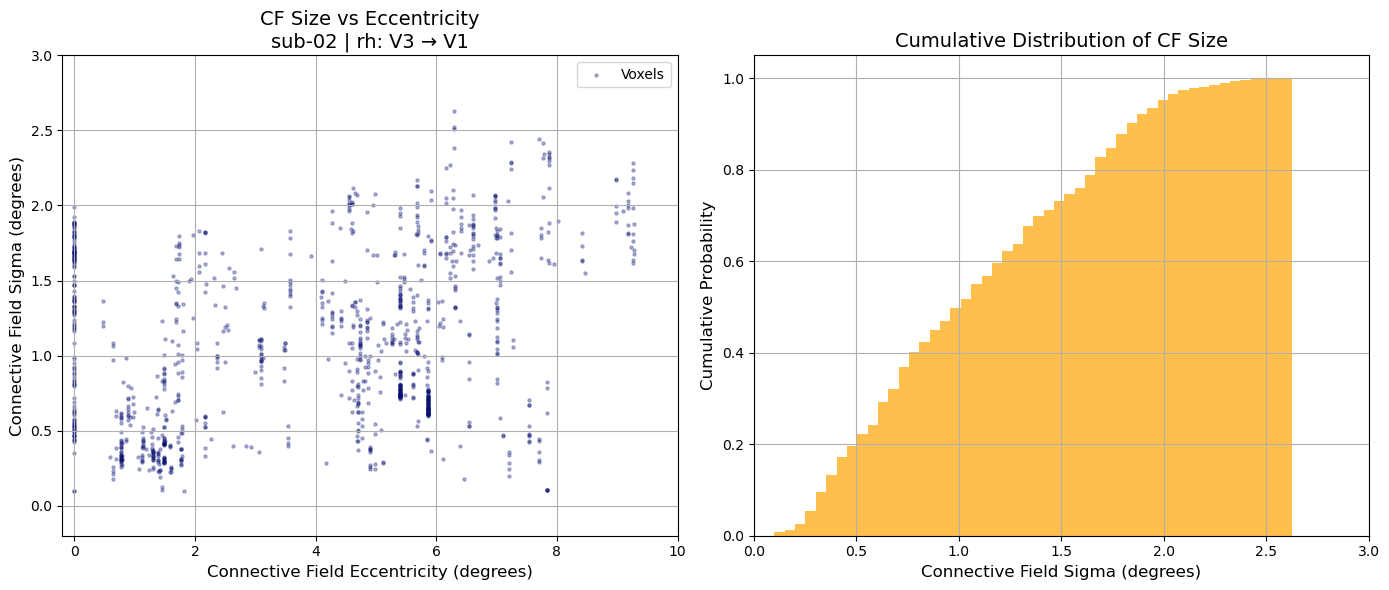

In [35]:
def trendline(subject_num, best_fit_df, hemi, target, source, output_dir=None, save=False):
    # Filter values
    best_fit_df = best_fit_df[best_fit_df["Best Sigma Finer"] > 0.1]
    ecc = best_fit_df["Source Eccentricity"].values
    sigma = best_fit_df["Best Sigma Finer"].values

    # Create figure with 1 row, 2 columns: scatter and CDF
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Scatter plot: Eccentricity vs Sigma
    axs[0].scatter(ecc, sigma, color='#0A1172', label='Voxels', s=5, alpha=0.3)
    axs[0].set_xlabel("Connective Field Eccentricity (degrees)", fontsize=12)
    axs[0].set_ylabel("Connective Field Sigma (degrees)", fontsize=12)
    axs[0].set_xlim(-0.2, 10)
    axs[0].set_ylim(-0.2, 3)
    axs[0].set_title(f"CF Size vs Eccentricity\n{subject_num} | {hemi}: {target} → {source}", fontsize=14)
    axs[0].grid(True)
    axs[0].legend(fontsize=10)

    # Cumulative Distribution Function (CDF) of Sigma
    axs[1].hist(sigma, bins=50, cumulative=True, density=True, color='orange', alpha=0.7)
    axs[1].set_xlabel("Connective Field Sigma (degrees)", fontsize=12)
    axs[1].set_ylabel("Cumulative Probability", fontsize=12)
    axs[1].set_xlim(0, 3)
    axs[1].set_title("Cumulative Distribution of CF Size", fontsize=14)
    axs[1].grid(True)

    plt.tight_layout()
    if save and output_dir:
        out_path = os.path.join(output_dir, f"{subject_num}_{hemi}_{target}_{source}_cf_plot.png")
        plt.savefig(out_path)
        print(f"Plot saved to {out_path}")
    plt.show()
        
best_fit_path = f'/Volumes/FedericaCardillo/results/{subj}/{hemi}/{target}->{source}/best_fits_prf.csv'
best_fit_df = pd.read_csv(best_fit_path)

# Plot
trendline(subj, best_fit_df=best_fit_df, hemi=hemi, target=target, source=source)